In [ ]:
from tensorflow.keras.layers import Activation, Dense, concatenate
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def build_generator(inputs, labels, image_size):
    """Build a Generator Model

    Stack of BN-ReLU-Conv2DTranpose to generate fake images
    Output activation is sigmoid instead of tanh.
    Sigmoid converges easily.

    Arguments:
        inputs (Layer): Input layer of the generator 
            the z-vector)
        image_size (tensor): Target size of one side
            (assuming square image)

    Returns:
        generator (Model): Generator Model
    """

    image_resize = image_size // 4
    # network parameters 
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    generator = Model([inputs, labels], x, name='generator')
    return generator

In [ ]:
def build_discriminator(inputs, labels, image_size):
    """Build a Discriminator Model

    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in original paper.

    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)

    Returns:
        discriminator (Model): Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    y = Dense(image_size * image_size * 1)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator

In [ ]:
discriminator_loss = []
adversarial_loss = []
def train(models, train, params):
  
    """Train the Discriminator and Adversarial Networks

    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly real and fake images.
    Adversarial is trained next with fake images pretending to be real
    Generate sample images per save_interval.

    Arguments:
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters

    """
    x_train, y_train = train
    #print(x_train)
    
    # the GAN component models
    generator, discriminator, adversarial = models
    # network parameters
    batch_size, latent_size, train_steps, num_labels, model_name = params
    
    # the generator image is saved every 500 steps
    save_interval = 100


    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # one-hot label the noise will be conditioned to
    noise_class = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    # number of elements in train dataset
    train_size = x_train.shape[0]
    print(model_name,
          "Labels for generated images: ",
          np.argmax(noise_class, axis=1))
    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # corresponding one-hot labels of real images
        real_labels = y_train[rand_indexes]
        # generate fake images from noise using generator 
        # generate noise using uniform distribution
        if i%1 == 0:
            noise = np.random.uniform(-1.0,
                                      1.0,
                                      size=[batch_size, latent_size])
            # assign random one-hot labels
            fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                              batch_size)]

            # generate fake images
            fake_images = generator.predict([noise, fake_labels])
            # real + fake images = 1 batch of train data
            x = np.concatenate((real_images, fake_images))
            # real + fake one-hot labels = 1 batch of train one-hot labels

            #real_labels = enc.transform(real_labels)
            labels = np.concatenate((real_labels, fake_labels))
            # label real and fake images
            # real images label is 1.0
            y = np.ones([2 * batch_size, 1])
            # fake images label is 0.0
            y[batch_size:, :] = 0.0
            # train discriminator network, log the loss and accuracy
            #print('x.shape', x.shape)
            #print('labels.shape', labels.shape)
            loss, acc = discriminator.train_on_batch([x, labels], y)
            log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

            discriminator_loss.append(loss)
        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0
        # since the discriminator weights 
        # are frozen in adversarial network
        # only the generator is trained
        # generate noise using uniform distribution
        if i%1 == 0:
            noise = np.random.uniform(-1.0,
                                      1.0, 
                                      size=[batch_size, latent_size])
            # assign random one-hot labels
            fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                              batch_size)]
            # label fake images as real or 1.0
            y = np.ones([batch_size, 1])
            # train the adversarial network 
            # note that unlike in discriminator training, 
            # we do not save the fake images in a variable
            # the fake images go to the discriminator input of the adversarial
            # for classification
            # log the loss and accuracy
            loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
            log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
            adversarial_loss.append(loss)
        
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=True,
                        step=(i + 1),
                        model_name=model_name)
   
    # save the model after training the generator
    # the trained generator can be reloaded for 
    # future MNIST digit generation
    generator.save(model_name + ".h5")
    
    
    return discriminator_loss,adversarial_loss

In [ ]:
def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    Arguments:
        generator (Model): The Generator Model for 
            fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict([noise_input, noise_class])
    plt.figure(figsize=(4.4, 4.4))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

In [ ]:
def build_and_train_models():
    # load fashion_mnist dataset
    (x_train, y_train), (_, _) = fashion_mnist.load_data()

     # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan_mnist"
    # network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    batch_size = 64
    train_steps = 1500
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    # [1] or original paper uses Adam, 
    # but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels],
                        outputs,
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)

In [ ]:
def test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                      batch_size)]
    plot_images(generator,
                noise_input=noise_input,
                fake_labels=fake_labels,
                show=True,
                model_name="test_outputs")

The time used to execute this is given below
4422102/4422102 [==============================] - 0s 0us/step
Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 class_labels (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 784)          8624        ['class_labels[0][0]']           
                                                                                                  
 discriminator_input (InputLaye  [(None, 28, 28, 1)]  0          []                               
 r)                                                                                               
                                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 z_input (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 class_labels (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 110)          0           ['z_input[0][0]',                
                                                                  'class_labels[0][0]']           
                                                                                                  
 dense_2 (Dense)                (None, 6272)         696192      ['concatenate_1[0][0]']  

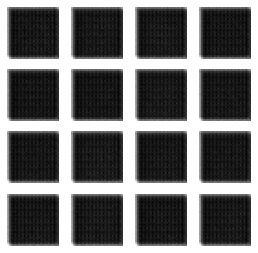

2/2 [==============================] - 0s 144ms/step
100: [discriminator loss: 0.009111, acc: 0.992188] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 141ms/step
101: [discriminator loss: 0.001432, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 138ms/step
102: [discriminator loss: 0.002733, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 136ms/step
103: [discriminator loss: 0.001946, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 140ms/step
104: [discriminator loss: 0.001605, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 140ms/step
105: [discriminator loss: 0.001346, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 145ms/step
106: [discriminator loss: 0.001221, acc: 1.000000] [adversa

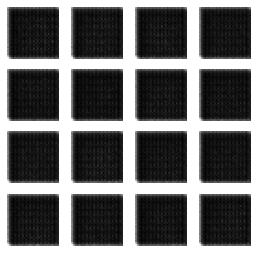

2/2 [==============================] - 0s 137ms/step
200: [discriminator loss: 0.000388, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 146ms/step
201: [discriminator loss: 0.000243, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 147ms/step
202: [discriminator loss: 0.000221, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 138ms/step
203: [discriminator loss: 0.000635, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 144ms/step
204: [discriminator loss: 0.000247, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 139ms/step
205: [discriminator loss: 0.000227, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 136ms/step
206: [discriminator loss: 0.000239, acc: 1.000000] [adversa

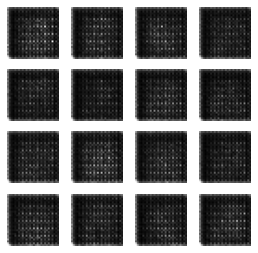

2/2 [==============================] - 0s 141ms/step
300: [discriminator loss: 0.000006, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 146ms/step
301: [discriminator loss: 0.000007, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 144ms/step
302: [discriminator loss: 0.000007, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 143ms/step
303: [discriminator loss: 0.000011, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 153ms/step
304: [discriminator loss: 0.000008, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 148ms/step
305: [discriminator loss: 0.000065, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 143ms/step
306: [discriminator loss: 0.000133, acc: 1.000000] [adversa

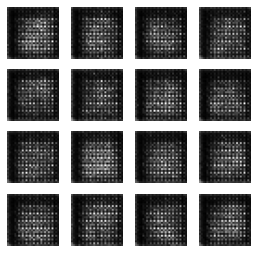

2/2 [==============================] - 0s 144ms/step
400: [discriminator loss: 0.000837, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 143ms/step
401: [discriminator loss: 0.002155, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 142ms/step
402: [discriminator loss: 0.000563, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 148ms/step
403: [discriminator loss: 0.000704, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 153ms/step
404: [discriminator loss: 0.000679, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 140ms/step
405: [discriminator loss: 0.000592, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 157ms/step
406: [discriminator loss: 0.000174, acc: 1.000000] [adversa

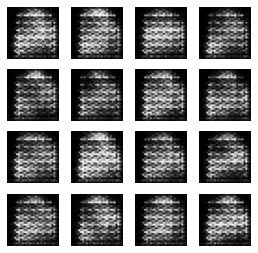

2/2 [==============================] - 0s 153ms/step
500: [discriminator loss: 0.298882, acc: 0.945312] [adversarial loss: 2.437303, acc: 0.000000]
2/2 [==============================] - 0s 147ms/step
501: [discriminator loss: 0.358986, acc: 0.867188] [adversarial loss: 0.364318, acc: 0.984375]
2/2 [==============================] - 0s 145ms/step
502: [discriminator loss: 0.614729, acc: 0.695312] [adversarial loss: 2.663907, acc: 0.000000]
2/2 [==============================] - 0s 137ms/step
503: [discriminator loss: 0.422251, acc: 0.875000] [adversarial loss: 0.564239, acc: 0.750000]
2/2 [==============================] - 0s 143ms/step
504: [discriminator loss: 0.286047, acc: 0.953125] [adversarial loss: 1.754953, acc: 0.000000]
2/2 [==============================] - 0s 142ms/step
505: [discriminator loss: 0.269756, acc: 0.921875] [adversarial loss: 0.721345, acc: 0.500000]
2/2 [==============================] - 0s 143ms/step
506: [discriminator loss: 0.273505, acc: 0.953125] [adversa

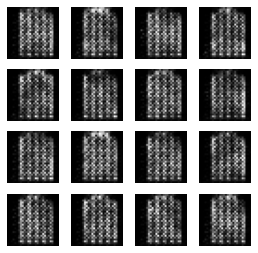

2/2 [==============================] - 0s 137ms/step
600: [discriminator loss: 0.592931, acc: 0.773438] [adversarial loss: 0.936265, acc: 0.296875]
2/2 [==============================] - 0s 154ms/step
601: [discriminator loss: 0.358136, acc: 0.812500] [adversarial loss: 2.781921, acc: 0.000000]
2/2 [==============================] - 0s 138ms/step
602: [discriminator loss: 0.151842, acc: 0.953125] [adversarial loss: 1.347037, acc: 0.031250]
2/2 [==============================] - 0s 142ms/step
603: [discriminator loss: 0.132230, acc: 0.984375] [adversarial loss: 2.259638, acc: 0.000000]
2/2 [==============================] - 0s 146ms/step
604: [discriminator loss: 0.115617, acc: 0.984375] [adversarial loss: 1.945153, acc: 0.000000]
2/2 [==============================] - 0s 139ms/step
605: [discriminator loss: 0.182665, acc: 0.937500] [adversarial loss: 1.172969, acc: 0.093750]
2/2 [==============================] - 0s 142ms/step
606: [discriminator loss: 0.160670, acc: 0.960938] [adversa

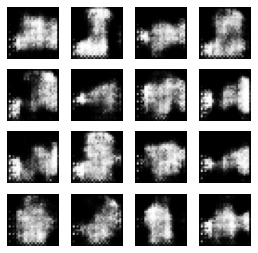

2/2 [==============================] - 0s 159ms/step
700: [discriminator loss: 0.449408, acc: 0.804688] [adversarial loss: 1.834461, acc: 0.109375]
2/2 [==============================] - 0s 152ms/step
701: [discriminator loss: 0.345519, acc: 0.867188] [adversarial loss: 1.541971, acc: 0.125000]
2/2 [==============================] - 0s 147ms/step
702: [discriminator loss: 0.350304, acc: 0.867188] [adversarial loss: 1.852396, acc: 0.046875]
2/2 [==============================] - 0s 153ms/step
703: [discriminator loss: 0.327159, acc: 0.898438] [adversarial loss: 1.373458, acc: 0.234375]
2/2 [==============================] - 0s 139ms/step
704: [discriminator loss: 0.472402, acc: 0.781250] [adversarial loss: 1.595344, acc: 0.140625]
2/2 [==============================] - 0s 143ms/step
705: [discriminator loss: 0.386015, acc: 0.820312] [adversarial loss: 1.360412, acc: 0.140625]
2/2 [==============================] - 0s 147ms/step
706: [discriminator loss: 0.348645, acc: 0.890625] [adversa

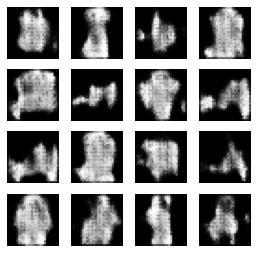

2/2 [==============================] - 0s 145ms/step
800: [discriminator loss: 0.577627, acc: 0.625000] [adversarial loss: 0.736732, acc: 0.531250]
2/2 [==============================] - 0s 144ms/step
801: [discriminator loss: 0.678119, acc: 0.679688] [adversarial loss: 1.837906, acc: 0.109375]
2/2 [==============================] - 0s 146ms/step
802: [discriminator loss: 0.586587, acc: 0.671875] [adversarial loss: 1.022988, acc: 0.343750]
2/2 [==============================] - 0s 141ms/step
803: [discriminator loss: 0.433747, acc: 0.789062] [adversarial loss: 1.525169, acc: 0.171875]
2/2 [==============================] - 0s 148ms/step
804: [discriminator loss: 0.467096, acc: 0.804688] [adversarial loss: 1.272089, acc: 0.187500]
2/2 [==============================] - 0s 144ms/step
805: [discriminator loss: 0.365717, acc: 0.882812] [adversarial loss: 1.030439, acc: 0.375000]
2/2 [==============================] - 0s 144ms/step
806: [discriminator loss: 0.370758, acc: 0.851562] [adversa

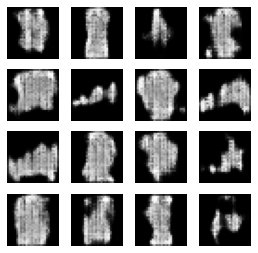

2/2 [==============================] - 0s 141ms/step
900: [discriminator loss: 0.526395, acc: 0.710938] [adversarial loss: 0.701829, acc: 0.562500]
2/2 [==============================] - 0s 150ms/step
901: [discriminator loss: 0.465837, acc: 0.773438] [adversarial loss: 1.803628, acc: 0.234375]
2/2 [==============================] - 0s 149ms/step
902: [discriminator loss: 0.533008, acc: 0.750000] [adversarial loss: 1.076278, acc: 0.343750]
2/2 [==============================] - 0s 144ms/step
903: [discriminator loss: 0.571367, acc: 0.765625] [adversarial loss: 1.709022, acc: 0.218750]
2/2 [==============================] - 0s 145ms/step
904: [discriminator loss: 0.566237, acc: 0.726562] [adversarial loss: 1.062655, acc: 0.375000]
2/2 [==============================] - 0s 140ms/step
905: [discriminator loss: 0.443723, acc: 0.796875] [adversarial loss: 1.742392, acc: 0.062500]
2/2 [==============================] - 0s 143ms/step
906: [discriminator loss: 0.424473, acc: 0.781250] [adversa

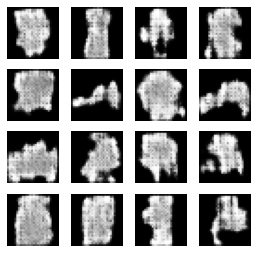

2/2 [==============================] - 0s 140ms/step
1000: [discriminator loss: 0.435063, acc: 0.789062] [adversarial loss: 2.137141, acc: 0.156250]
2/2 [==============================] - 0s 140ms/step
1001: [discriminator loss: 0.422620, acc: 0.773438] [adversarial loss: 1.362469, acc: 0.296875]
2/2 [==============================] - 0s 150ms/step
1002: [discriminator loss: 0.451485, acc: 0.804688] [adversarial loss: 1.774719, acc: 0.062500]
2/2 [==============================] - 0s 147ms/step
1003: [discriminator loss: 0.405186, acc: 0.820312] [adversarial loss: 1.444837, acc: 0.203125]
2/2 [==============================] - 0s 142ms/step
1004: [discriminator loss: 0.458747, acc: 0.773438] [adversarial loss: 1.794969, acc: 0.078125]
2/2 [==============================] - 0s 136ms/step
1005: [discriminator loss: 0.459648, acc: 0.796875] [adversarial loss: 1.146097, acc: 0.390625]
2/2 [==============================] - 0s 151ms/step
1006: [discriminator loss: 0.488472, acc: 0.757812] [

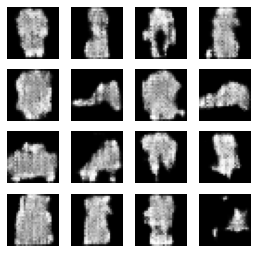

2/2 [==============================] - 0s 152ms/step
1100: [discriminator loss: 0.445163, acc: 0.789062] [adversarial loss: 1.356647, acc: 0.250000]
2/2 [==============================] - 0s 155ms/step
1101: [discriminator loss: 0.486985, acc: 0.789062] [adversarial loss: 1.248723, acc: 0.234375]
2/2 [==============================] - 0s 143ms/step
1102: [discriminator loss: 0.440112, acc: 0.781250] [adversarial loss: 1.465611, acc: 0.109375]
2/2 [==============================] - 0s 144ms/step
1103: [discriminator loss: 0.431057, acc: 0.843750] [adversarial loss: 1.101222, acc: 0.343750]
2/2 [==============================] - 0s 152ms/step
1104: [discriminator loss: 0.487711, acc: 0.757812] [adversarial loss: 1.588551, acc: 0.265625]
2/2 [==============================] - 0s 146ms/step
1105: [discriminator loss: 0.406112, acc: 0.820312] [adversarial loss: 1.098929, acc: 0.328125]
2/2 [==============================] - 0s 147ms/step
1106: [discriminator loss: 0.499016, acc: 0.765625] [

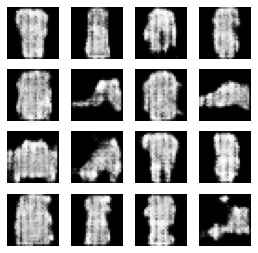

2/2 [==============================] - 0s 138ms/step
1200: [discriminator loss: 0.409268, acc: 0.812500] [adversarial loss: 1.114782, acc: 0.343750]
2/2 [==============================] - 0s 144ms/step
1201: [discriminator loss: 0.497961, acc: 0.765625] [adversarial loss: 1.460061, acc: 0.109375]
2/2 [==============================] - 0s 158ms/step
1202: [discriminator loss: 0.481532, acc: 0.812500] [adversarial loss: 1.505332, acc: 0.046875]
2/2 [==============================] - 0s 140ms/step
1203: [discriminator loss: 0.387855, acc: 0.851562] [adversarial loss: 1.244612, acc: 0.156250]
2/2 [==============================] - 0s 141ms/step
1204: [discriminator loss: 0.483006, acc: 0.757812] [adversarial loss: 1.295053, acc: 0.171875]
2/2 [==============================] - 0s 139ms/step
1205: [discriminator loss: 0.497532, acc: 0.781250] [adversarial loss: 1.180146, acc: 0.312500]
2/2 [==============================] - 0s 139ms/step
1206: [discriminator loss: 0.512736, acc: 0.765625] [

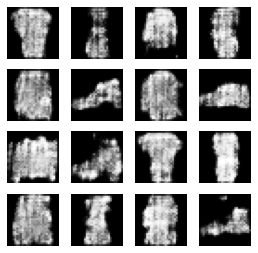

2/2 [==============================] - 0s 144ms/step
1300: [discriminator loss: 0.504035, acc: 0.718750] [adversarial loss: 1.312665, acc: 0.265625]
2/2 [==============================] - 0s 147ms/step
1301: [discriminator loss: 0.570172, acc: 0.656250] [adversarial loss: 1.370752, acc: 0.250000]
2/2 [==============================] - 0s 145ms/step
1302: [discriminator loss: 0.468365, acc: 0.765625] [adversarial loss: 1.057984, acc: 0.218750]
2/2 [==============================] - 0s 153ms/step
1303: [discriminator loss: 0.604749, acc: 0.750000] [adversarial loss: 1.005175, acc: 0.296875]
2/2 [==============================] - 0s 147ms/step
1304: [discriminator loss: 0.477610, acc: 0.789062] [adversarial loss: 0.986860, acc: 0.234375]
2/2 [==============================] - 0s 149ms/step
1305: [discriminator loss: 0.474631, acc: 0.804688] [adversarial loss: 0.973184, acc: 0.343750]
2/2 [==============================] - 0s 151ms/step
1306: [discriminator loss: 0.580119, acc: 0.664062] [

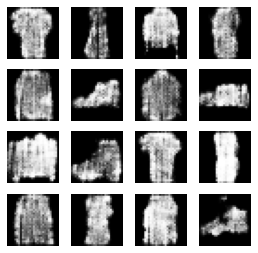

2/2 [==============================] - 0s 143ms/step
1400: [discriminator loss: 0.565712, acc: 0.710938] [adversarial loss: 0.940172, acc: 0.421875]
2/2 [==============================] - 0s 154ms/step
1401: [discriminator loss: 0.548044, acc: 0.703125] [adversarial loss: 1.269862, acc: 0.328125]
2/2 [==============================] - 0s 139ms/step
1402: [discriminator loss: 0.569672, acc: 0.679688] [adversarial loss: 0.908157, acc: 0.468750]
2/2 [==============================] - 0s 147ms/step
1403: [discriminator loss: 0.615502, acc: 0.640625] [adversarial loss: 1.433382, acc: 0.140625]
2/2 [==============================] - 0s 149ms/step
1404: [discriminator loss: 0.678777, acc: 0.593750] [adversarial loss: 0.858301, acc: 0.468750]
2/2 [==============================] - 0s 147ms/step
1405: [discriminator loss: 0.564569, acc: 0.726562] [adversarial loss: 0.932291, acc: 0.234375]
2/2 [==============================] - 0s 140ms/step
1406: [discriminator loss: 0.555735, acc: 0.726562] [

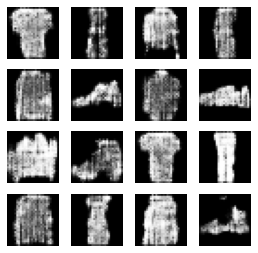

2360.238459587097


In [ ]:
import time

start = time.time()

print("The time used to execute this is given below")

end = time.time()


if __name__ == '__main__':
    build_and_train_models()

end = time.time()
    
print(end - start)

In [ ]:
epoch = range(1,len(discriminator_loss)+1)  

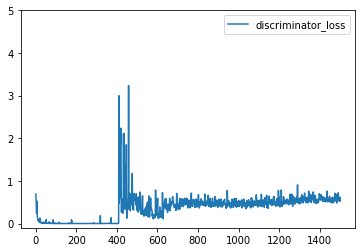

In [ ]:
plt.plot(epoch,discriminator_loss)
plt.legend(['discriminator_loss'])
plt.ylim(-0.1,5)
plt.show()

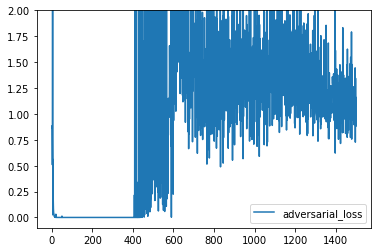

In [ ]:
plt.plot(epoch,adversarial_loss)
plt.legend(['adversarial_loss'])
plt.ylim(-0.1,2)
plt.show()

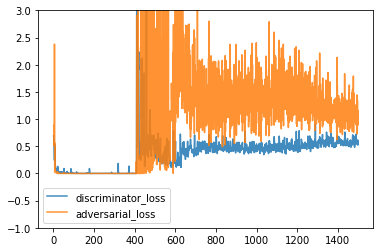

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch,discriminator_loss,epoch,adversarial_loss, alpha=0.85)
plt.legend(['discriminator_loss', 'adversarial_loss'])
plt.ylim(-1,3)
plt.show()